In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from pathlib import Path
import sys
import torch

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [7]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
   
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")

    for i in range(len(y_labels)):
        df[f"Std_samples_{y_labels[i]}"] = np.std(np.array(data["samples"][:, :, i]), axis=-1)

    df["Confidence"] = data["confidence"]
    
    # Get truth label values (annoying because text is not read as text, should fix)
    # Is fixed, just update
    if (test == False):
        df["Truth_value"] = data["truth"]
        df["Truth"] = y_labels[0]
        blue = 1.0
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == blue
        df.loc[mask, "Truth"] = y_labels[1]
    
    # Get estimated probabilities
    for i in range(len(y_labels)):
        df[y_labels[i]] = data["probabilities"][:,i]
        df[f"P({y_labels[i]}|x)"] = data["probabilities"][:,i]

    # Get 25-75% error bars
    for i in range(len(y_labels)):
        df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
        df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
        df[f"Error_{y_labels[i]}"] = (df[f"quantile75_{y_labels[i]}"] - df[f"quantile25_{y_labels[i]}"])/2

    # Could be some NaNs
    len_nan = len(df[df.isnull().any(axis=1)])
    if len_nan > 0:
        print(f"Dropping {len_nan} rows of NaNs from file {file}")
        df = df.dropna()
    
    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
    
    return df

In [39]:
def plot_results(df, weight_key, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[weight_key], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=weight_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    size="Std_samples_blue", size_norm = (0.1, 0.3), sizes=(10, 200),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [11]:
# Setup

#MCMC constants
n_samples = 1200
n_data = [250, 1000, 2000, 5000]
#n_cal = [250, 500, 750, 1000, 1250, 1500, 1750, 2000]
n_cal = 1000
n_chains = 10
n_plots = len(n_data)

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Data labels
y_labels = ["red", "blue"]
x_labels = ["x1", "x2"]

# Read files
folderpath = "calibrate"
#train_n = 5000
calfile = f"val_n_5000_{tag}"
testfiles = [f"test_n_10000_{tag}_predicted_SequentialNet_10ensembles_ndata-{n_data[i]}" for i in range(n_plots)]
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_200_nr1MC_200"
gridfiles = [f"grid_{tag}_predicted_SequentialNet_10ensembles_ndata-{n_data[i]}" for i in range(n_plots)]
trainfile = f"train_n_50000_{tag}"

if polar:
    analysis_folders = [f"{calfile}_predicted_SequentialNet_10ensembles_ndata-{n_data[i]}/nsamples-1200_nchains-{n_chains}_ncal-{n_cal}_POLAR" for i in range(n_plots)]
else:
    analysis_folders = [f"{calfile}_predicted_SequentialNet_10ensembles_ndata-{n_data[i]}/nsamples-1200_nchains-{n_chains}_ncal-{n_cal}" for i in range(n_plots)]
cal_data = [pd.read_csv(f"../DNN/predictions/{trainfile}/{calfile}_predicted_SequentialNet_10ensembles_ndata-{n_data[i]}.csv") for i in range(n_plots)]
test_data = [pd.read_csv(f"../DNN/predictions/{trainfile}/{testfiles[i]}.csv") for i in range(n_plots)]
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
gridfiles = [f"{folderpath}/{analysis_folders[i]}/{gridfiles[i]}_inferred.h5"  for i in range(n_plots)]
testfiles = [f"{folderpath}/{analysis_folders[i]}/{testfiles[i]}_inferred.h5"  for i in range(n_plots)]

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

test_dfs = [0]*n_plots
grid_dfs = [0]*n_plots

for i in range(n_plots):
    df_test = process_data(testfiles[i], y_labels, x_labels)
    df_grid = process_data(gridfiles[i], y_labels, x_labels, test=True)
    test_dfs[i] = df_test
    grid_dfs[i] = df_grid

# Key to use for plotting
weight_key = f"P({y_labels[1]}|x)"

In [12]:
test_dfs[0]

,x1,x2,r_x,a_x,Std_samples_red,Std_samples_blue,Confidence,Truth_value,Truth,red,P(red|x),blue,P(blue|x),quantile25_red,quantile75_red,Error_red,quantile25_blue,quantile75_blue,Error_blue,Inferred_color
0,4.637181,11.350187,12.260921,1.182936,0.095206,0.095206,0.307059,0.0,red,0.609593,0.609593,0.390407,0.390407,0.555173,0.673042,0.058934,0.326958,0.444827,0.058934,red
1,10.042744,10.382106,14.444543,0.802012,0.109900,0.109900,0.261233,0.0,red,0.558809,0.558809,0.441191,0.441191,0.498247,0.627076,0.064415,0.372924,0.501753,0.064415,red
2,-5.605532,11.920284,13.172515,2.010363,0.105189,0.105189,0.251218,1.0,blue,0.556698,0.556698,0.443302,0.443302,0.496357,0.614631,0.059137,0.385369,0.503643,0.059137,red
3,-1.477669,-14.679668,14.753853,4.612066,0.110135,0.110135,0.165183,1.0,blue,0.724635,0.724635,0.275365,0.275365,0.665732,0.803313,0.068791,0.196687,0.334268,0.068791,red
4,-9.945727,8.379890,13.005386,2.441433,0.089479,0.089479,0.240928,1.0,blue,0.493477,0.493477,0.506523,0.506523,0.427467,0.560332,0.066433,0.439668,0.572533,0.066433,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.596807,9.253463,9.272689,1.506390,0.099190,0.099190,0.396358,0.0,red,0.468544,0.468544,0.531456,0.531456,0.413298,0.528614,0.057658,0.471386,0.586702,0.057658,blue
9996,-6.404741,6.863661,9.387787,2.321621,0.082741,0.082741,0.362476,1.0,blue,0.517635,0.517635,0.482365,0.482365,0.466958,0.572302,0.052672,0.427698,0.533042,0.052672,red
9997,-11.277142,2.093363,11.469791,2.958053,0.098922,0.098922,0.269789,1.0,blue,0.581334,0.581334,0.418666,0.418666,0.506367,0.656920,0.075276,0.343080,0.493633,0.075276,red
9998,8.927445,11.836816,14.825974,0.924606,0.099777,0.099777,0.247631,0.0,red,0.512684,0.512684,0.487316,0.487316,0.449069,0.574078,0.062504,0.425922,0.550931,0.062504,red


Text(0.5, 0.98, 'Number of datapoints: 250')

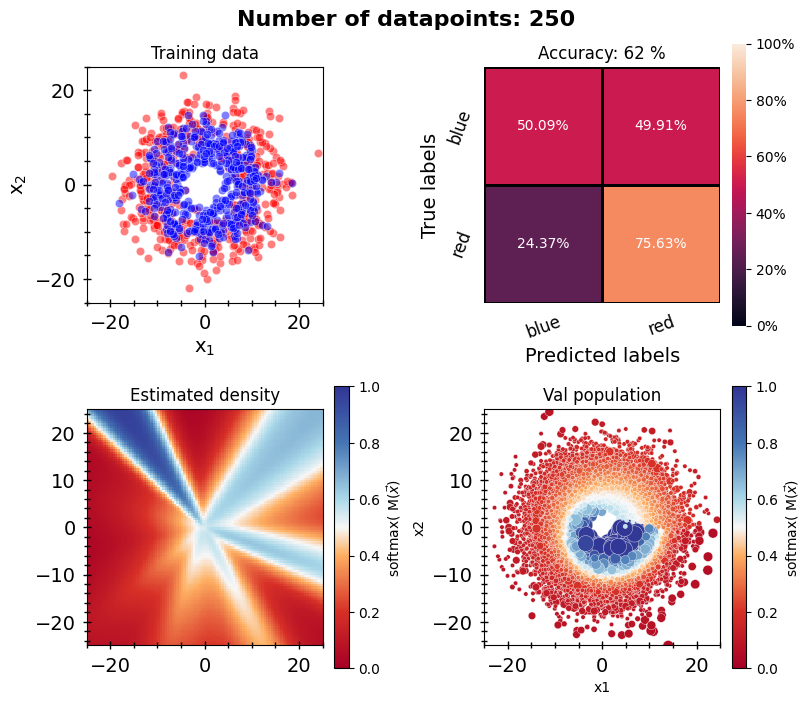

In [18]:

# Plot animation

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")

#plot data
axs[0][0] = plot_data(cal_data[0][0:n_cal], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(test_dfs[0], "Truth", "Inferred_color", ["blue", "red"], axs[0][1])
axs[1][0] = plot_results(grid_dfs[0], "Confidence", axs[1][0], "Estimated density", grid=True)
axs[1][1] = plot_results(test_dfs[0], "Confidence", axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: {n_data[0]}", size=16, fontweight="bold")

#plt.show()
    

In [ ]:
df_test

,x1,x2,r_x,a_x,Confidence,Truth_value,Truth,red,P(red|x),blue,P(blue|x),quantile25_red,quantile75_red,Error_red,quantile25_blue,quantile75_blue,Error_blue,Inferred_color
0,4.637181,11.350187,12.260921,1.182936,0.354201,0.0,red,0.629173,0.629173,0.370827,0.370827,0.592290,0.675470,0.041590,0.324530,0.407710,0.041590,red
1,10.042744,10.382106,14.444543,0.802012,0.246766,0.0,red,0.803942,0.803942,0.196058,0.196058,0.768040,0.845464,0.038712,0.154536,0.231960,0.038712,red
2,-5.605532,11.920284,13.172515,2.010363,0.251546,1.0,blue,0.802188,0.802188,0.197812,0.197812,0.767513,0.840895,0.036691,0.159105,0.232487,0.036691,red
3,-1.477669,-14.679668,14.753853,4.612066,0.158470,1.0,blue,0.878549,0.878549,0.121451,0.121451,0.851756,0.916364,0.032304,0.083636,0.148244,0.032304,red
4,-9.945727,8.379890,13.005386,2.441433,0.270930,1.0,blue,0.766163,0.766163,0.233837,0.233837,0.734222,0.806338,0.036058,0.193662,0.265778,0.036058,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.596807,9.253463,9.272689,1.506390,0.686657,0.0,red,0.347121,0.347121,0.652879,0.652879,0.307475,0.380888,0.036706,0.619112,0.692525,0.036706,blue
9996,-6.404741,6.863661,9.387787,2.321621,0.600500,1.0,blue,0.339607,0.339607,0.660393,0.660393,0.301379,0.380110,0.039365,0.619890,0.698621,0.039365,blue
9997,-11.277142,2.093363,11.469791,2.958053,0.495610,1.0,blue,0.492448,0.492448,0.507552,0.507552,0.442242,0.540197,0.048978,0.459803,0.557758,0.048978,blue
9998,8.927445,11.836816,14.825974,0.924606,0.225333,0.0,red,0.849067,0.849067,0.150933,0.150933,0.819691,0.882929,0.031619,0.117071,0.180309,0.031619,red


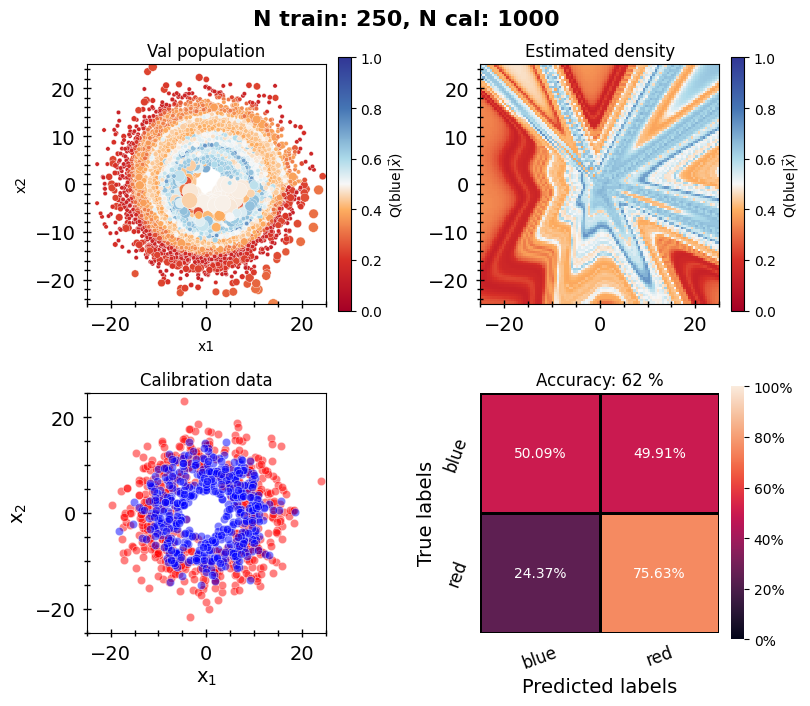

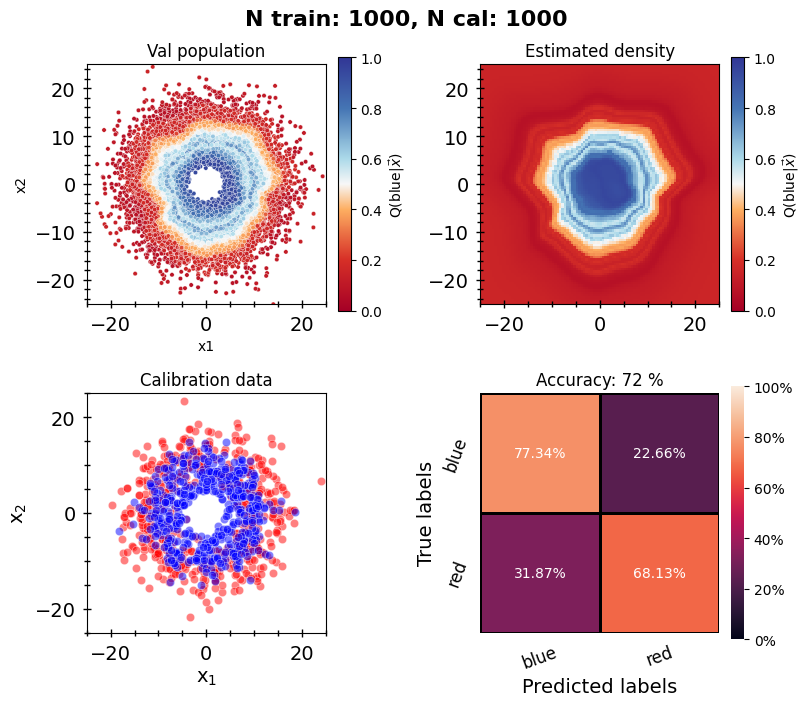

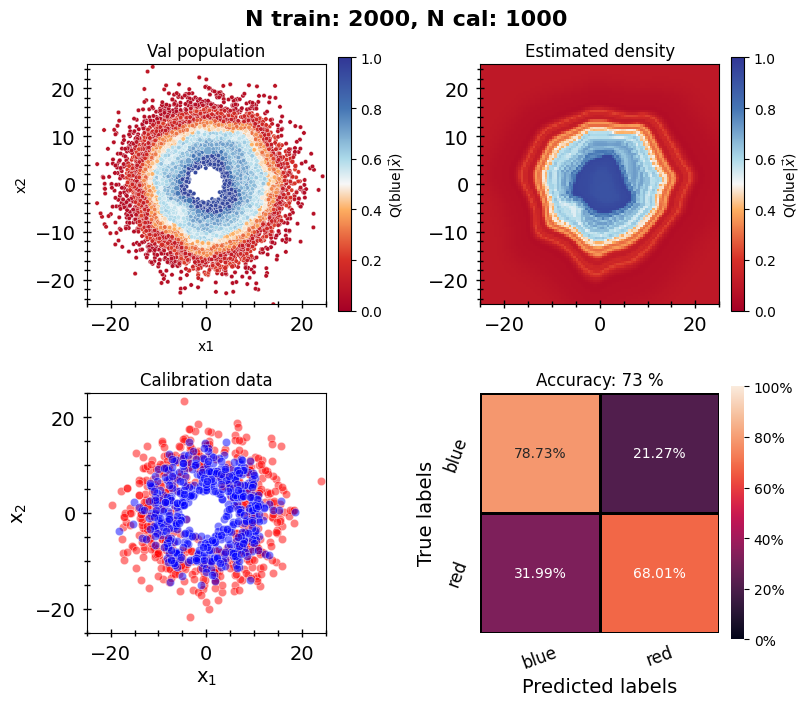

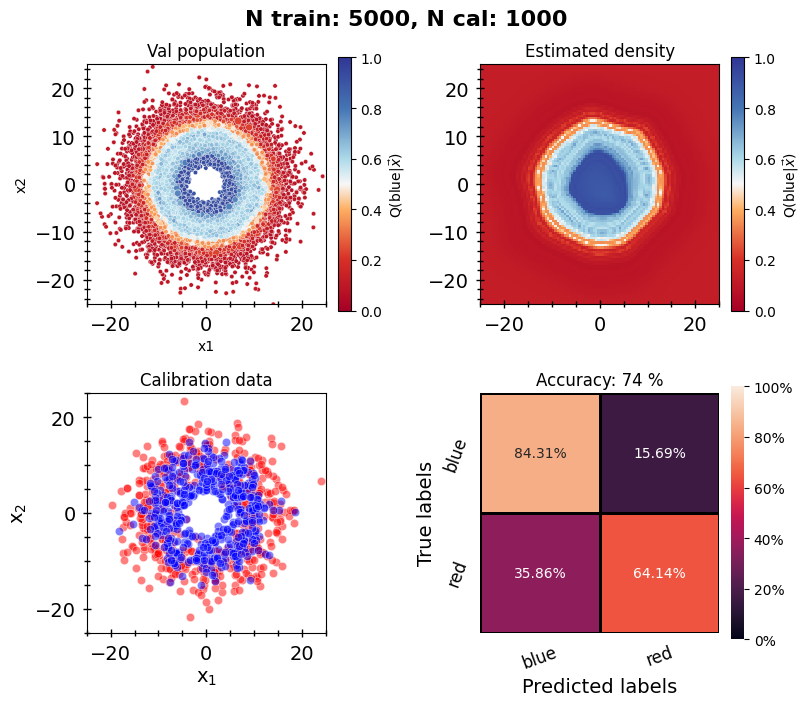

In [34]:

for i in range(n_plots):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_results(test_dfs[i], weight_key, axs[0][0], "Val population")
    axs[0][1] = plot_results(grid_dfs[i], weight_key, axs[0][1], "Estimated density", grid=True)
    axs[1][0] = plot_data(cal_data[i][0:n_cal], axs[1][0], "Calibration data")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "Truth", "Inferred_color", ["blue", "red"], axs[1][1])
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"N train: {n_data[i]}, N cal: {n_cal}", size=16, fontweight="bold")

#plt.show()
    

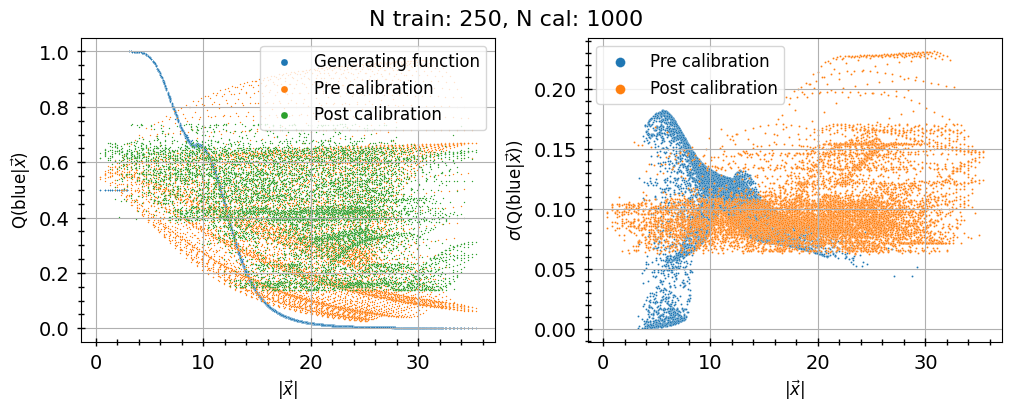

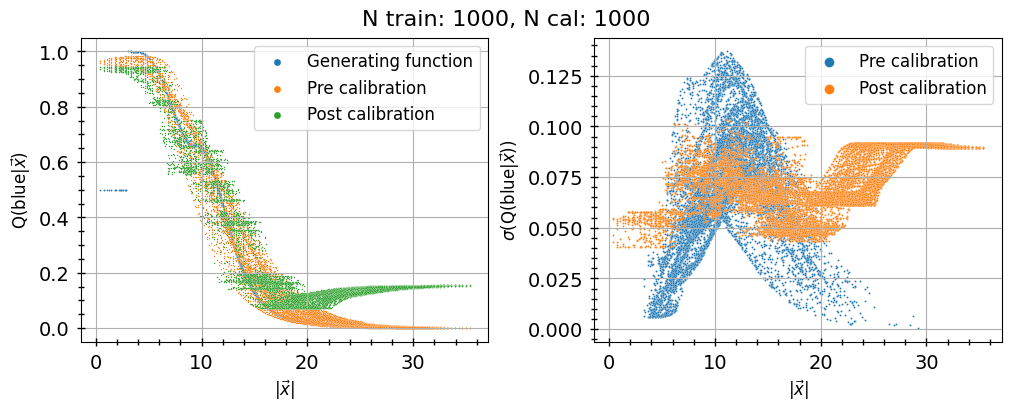

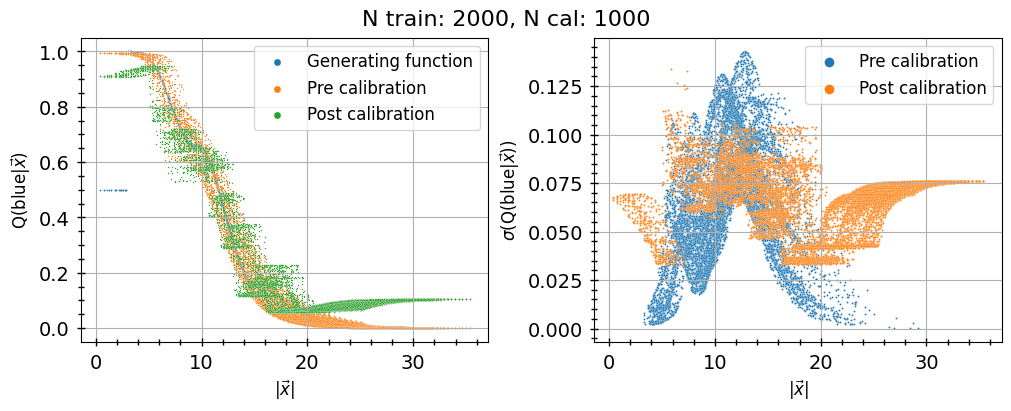

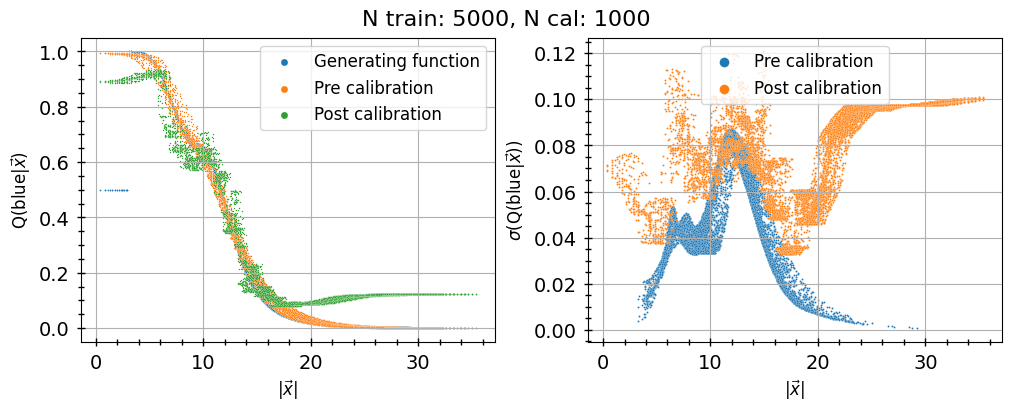

In [32]:
for i in range(n_plots):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=1, ax = axs[0], label="Generating function")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence", s=1, ax = axs[0], label = "Pre calibration")
    #sn.scatterplot(test_data, x="r_x", y="Confidence_avg", s=1, ax = axs[0], label = "Pre calibration check")
    sn.scatterplot(grid_dfs[i], x="r_x", y="P(blue|x)", s=1, ax = axs[0], label = "Post calibration")

    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    sn.scatterplot(test_data[i], x="r_x", y="Confidence_std", s=2, ax = axs[1], label="Pre calibration")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Std_samples_blue", s=2, ax = axs[1], label="Post calibration")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=12)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=12)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"N train: {n_data[i]}, N cal: {n_cal}", fontsize=16)


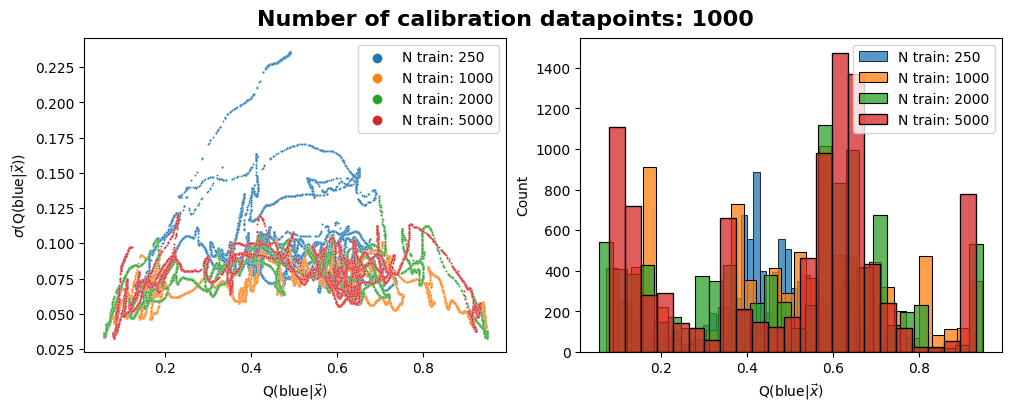

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(n_plots):
    sn.scatterplot(test_dfs[i], x="P(blue|x)", y="Std_samples_blue", s=2, label=f"N train: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))")
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)")
    sn.histplot(test_dfs[i], x="P(blue|x)", label=f"N train: {n_data[i]}", ax = axs[1])
    axs[1].legend(markerscale=5)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    fig.suptitle(f"Number of calibration datapoints: {n_cal}", size=16, fontweight="bold")

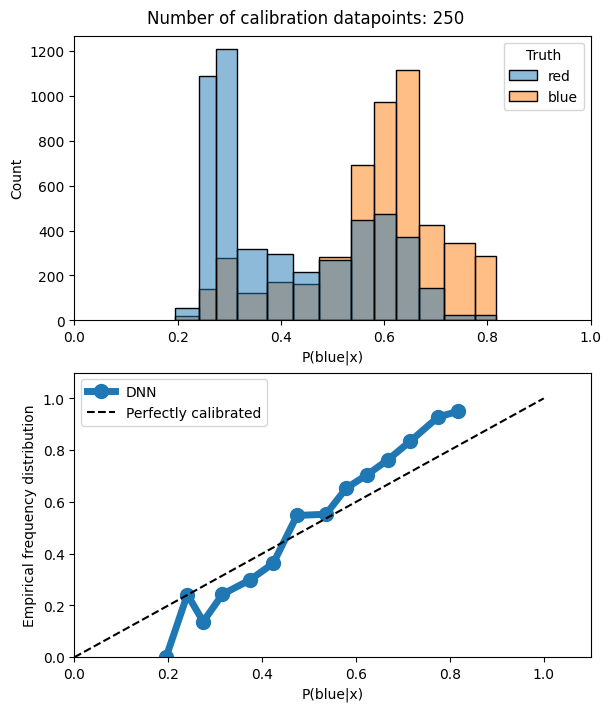

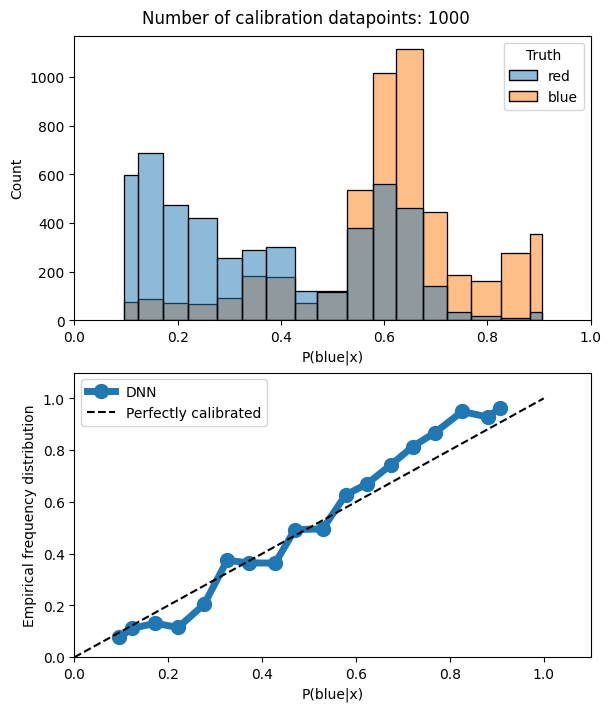

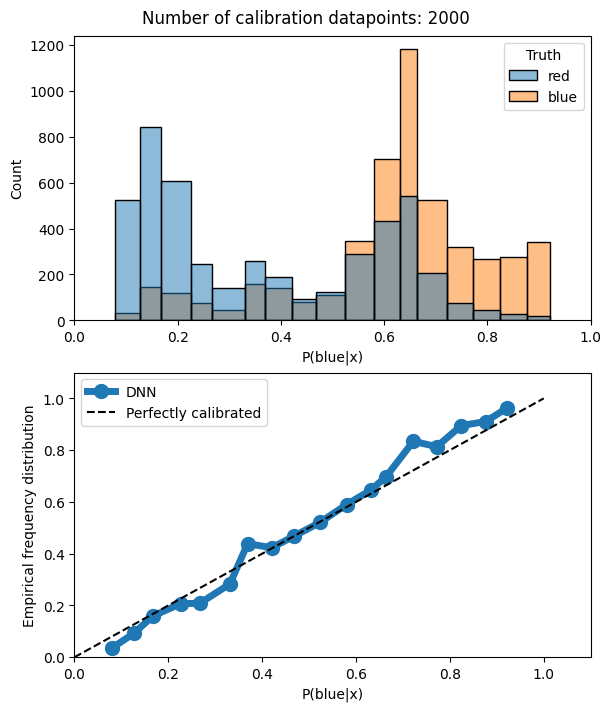

In [ ]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(len(n_cal)):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["Truth_value"], test_dfs[i]["P(blue|x)"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="P(blue|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of calibration datapoints: {n_cal}")

Text(0, 0.5, 'Probability')

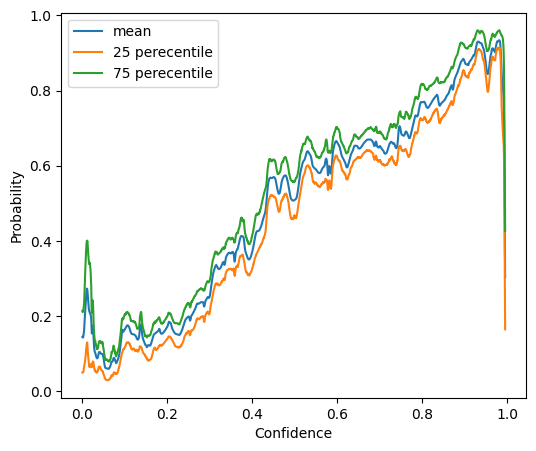

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
sn.lineplot(test_dfs[-1], x="Confidence", y="blue", label="mean", ax=ax)
sn.lineplot(test_dfs[-1], x="Confidence", y="quantile25_blue", label = "25 perecentile", ax=ax)
sn.lineplot(test_dfs[-1], x="Confidence", y="quantile75_blue", label = "75 perecentile", ax=ax)
ax.legend()
ax.set_ylabel("Probability")